In [1]:
# Update variable name from `mock_data` to `full_data`
# This assumes the original code from the user is being updated
import pandas as pd
import ast

# Load data generated from ScispaCy pipeline
data_path = "labeled_notes_with_symptoms.csv"
full_data = pd.read_csv(data_path)

# Convert stringified lists back into Python lists
full_data["SYMPTOMS"] = full_data["SYMPTOMS"].apply(ast.literal_eval)

# Show preview
print("Data loaded:")
print(full_data[["SYMPTOMS", "ICD9_CODE"]].head())

Data loaded:
                                            SYMPTOMS ICD9_CODE
0  [infant, large for gestational age, nasal (int...      2851
1  [kidney cancer ptx tnm finding v6 and v7, deco...      2761
2  [tricuspid valve insufficiency, nose diseases,...      4019
3  [tumor results original result, atonic seizure...      5070
4  [large head (disorder), increased head circumf...      V053


In [2]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

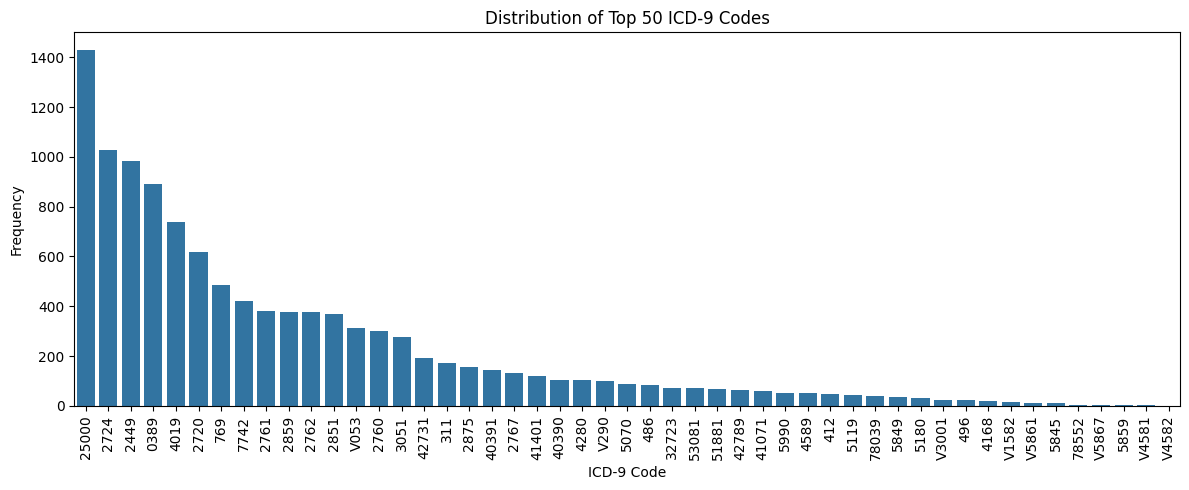

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize label distribution
label_counts = full_data["ICD9_CODE"].value_counts()

plt.figure(figsize=(12, 5))
sns.barplot(x=label_counts.index[:50], y=label_counts.values[:50])
plt.title("Distribution of Top 50 ICD-9 Codes")
plt.xlabel("ICD-9 Code")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [4]:
# Inspect column names and types
print("Column names:", full_data.columns.tolist())
print("\nData types:")
print(full_data.dtypes)

# Check how many rows have at least one symptom
non_empty_symptoms = full_data["SYMPTOMS"].apply(lambda x: len(x) > 0).sum()
print(f"\nRows with at least one symptom: {non_empty_symptoms} / {len(full_data)}")

Column names: ['HADM_ID', 'SYMPTOMS', 'ICD9_CODE']

Data types:
HADM_ID      float64
SYMPTOMS      object
ICD9_CODE     object
dtype: object

Rows with at least one symptom: 11133 / 11138


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# Step 1: TF-IDF Vectorization
corpus = full_data["SYMPTOMS"].apply(lambda x: ' '.join(x))
tfidf = TfidfVectorizer()
X_tfidf_scaled = tfidf.fit_transform(corpus)
print("TF-IDF shape:", X_tfidf_scaled.shape)

# Step 2: Train Word2Vec on tokenized symptom lists
w2v_model = Word2Vec(
    sentences=full_data["SYMPTOMS"],
    vector_size=50,
    window=2,
    min_count=1,
    workers=4,
    seed=42
)
print("Word2Vec training complete.")

# Step 3: Average Word2Vec vector per row
def avg_vector(symptoms, model, dim=50):
    vectors = [model.wv[word] for word in symptoms if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(dim)

X_w2v = np.array([avg_vector(sym, w2v_model) for sym in full_data["SYMPTOMS"]])
print("Word2Vec shape:", X_w2v.shape)

# Step 4: Store full Word2Vec sequences for BiLSTM / Hybrid use
sequence_vectors = []
for symptoms in full_data["SYMPTOMS"]:
    vectors = [w2v_model.wv[word] for word in symptoms if word in w2v_model.wv]
    if vectors:
        sequence_vectors.append(torch.tensor(vectors, dtype=torch.float32))
    else:
        sequence_vectors.append(None)  # empty

# Step 5: Valid index tracking
valid_indices = [i for i, vec in enumerate(sequence_vectors) if vec is not None]

TF-IDF shape: (11138, 7434)
Word2Vec training complete.
Word2Vec shape: (11138, 50)


C:\Users\Allen\AppData\Local\Temp\ipykernel_11864\3021671467.py:40: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  sequence_vectors.append(torch.tensor(vectors, dtype=torch.float32))


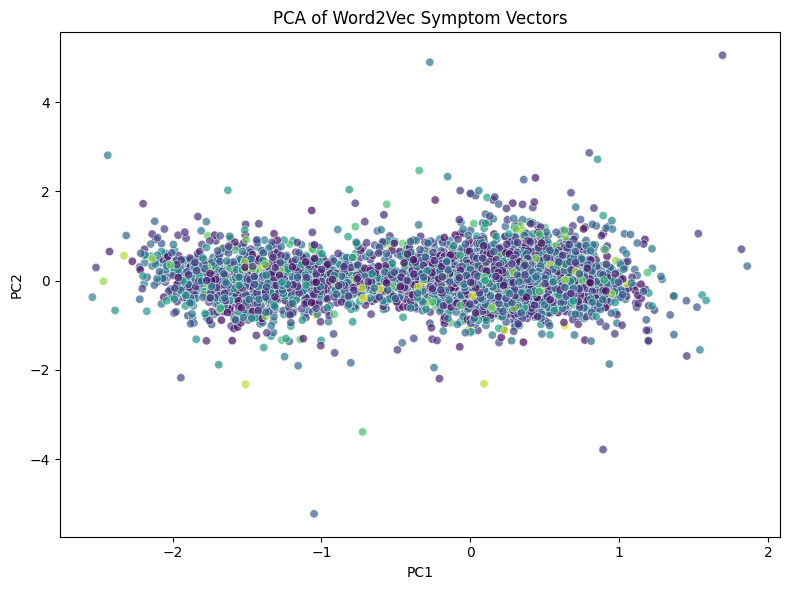

In [6]:
# Reduce dimensionality with PCA for visualization
pca = PCA(n_components=2)
reduced_w2v = pca.fit_transform(X_w2v)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=reduced_w2v[:, 0], y=reduced_w2v[:, 1], hue=full_data["ICD9_CODE"], palette="viridis", legend=False, alpha=0.7)
plt.title("PCA of Word2Vec Symptom Vectors")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

C:\Users\Allen\anaconda3\envs\disease_bilstm\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


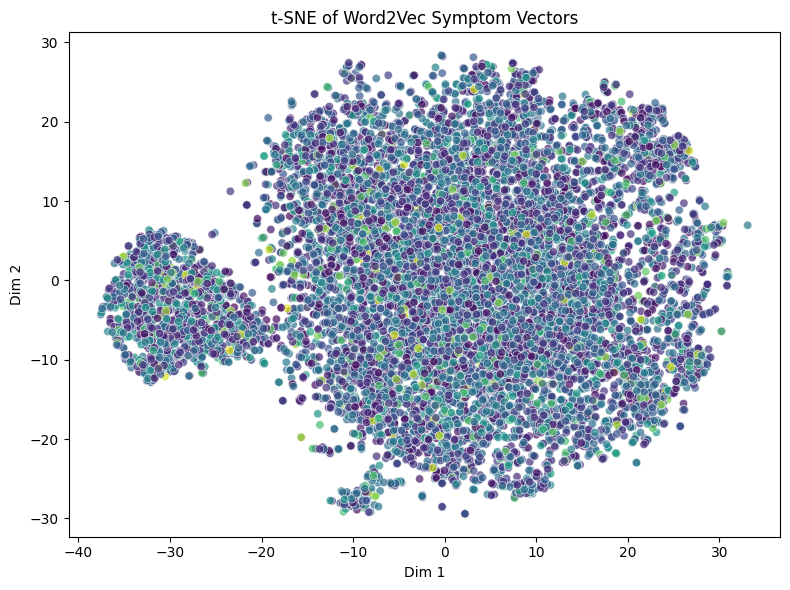

In [7]:
# Optional: t-SNE for deeper cluster visualization
tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=500)
reduced_tsne = tsne.fit_transform(X_w2v)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=reduced_tsne[:, 0], y=reduced_tsne[:, 1], hue=full_data["ICD9_CODE"], palette="viridis", legend=False, alpha=0.7)
plt.title("t-SNE of Word2Vec Symptom Vectors")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.tight_layout()
plt.show()

C:\Users\Allen\AppData\Local\Temp\ipykernel_11864\2673469567.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=encoded_labels, y=np.bincount(labels), palette="Blues_d")


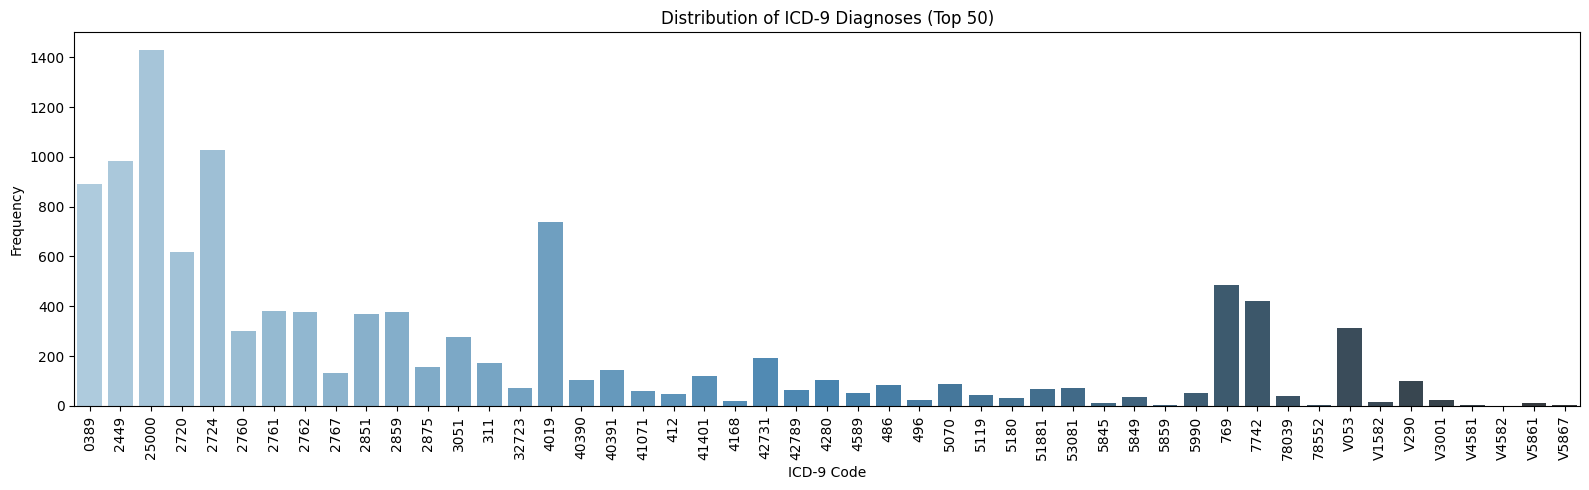

Ready for model input: torch.Size([11132, 546, 50]), 49 classes


In [8]:
from sklearn.preprocessing import LabelEncoder
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Step 1: Label encode ICD-9 codes
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(full_data["ICD9_CODE"])
labels_tensor = torch.tensor(labels, dtype=torch.long)

# Step 2: Convert symptom sequences to Word2Vec embeddings
sequence_vectors = []
for symptoms in full_data["SYMPTOMS"]:
    vectors = [w2v_model.wv[word] for word in symptoms if word in w2v_model.wv]
    if vectors:
        sequence_vectors.append(torch.tensor(np.array(vectors), dtype=torch.float32))
    else:
        sequence_vectors.append(None)

# Step 3: Filter out empty sequences
valid_indices = [i for i, vec in enumerate(sequence_vectors) if vec is not None]
filtered_sequences = [sequence_vectors[i] for i in valid_indices]
filtered_labels = labels_tensor[valid_indices]

# Step 4: Remove classes with <2 instances
label_counts = Counter(filtered_labels.tolist())
valid_label_set = {label for label, count in label_counts.items() if count >= 2}

final_indices = [i for i, label in enumerate(filtered_labels) if label.item() in valid_label_set]
filtered_sequences = [filtered_sequences[i] for i in final_indices]
filtered_labels = filtered_labels[final_indices]

# Step 5: Pad sequences
padded_sequences = pad_sequence(filtered_sequences, batch_first=True)

# Step 6: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, filtered_labels, test_size=0.3, stratify=filtered_labels, random_state=42
)

# Step 7: PyTorch DataLoaders
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=32)

# Step 8: Visualize class distribution
encoded_labels = label_encoder.transform(label_encoder.classes_)  # for plotting
label_names = label_encoder.classes_

plt.figure(figsize=(16, 5))
sns.barplot(x=encoded_labels, y=np.bincount(labels), palette="Blues_d")
plt.xticks(ticks=encoded_labels, labels=label_names, rotation=90)
plt.title("Distribution of ICD-9 Diagnoses (Top 50)")
plt.xlabel("ICD-9 Code")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Final confirmation
print(f"Ready for model input: {padded_sequences.shape}, {len(label_encoder.classes_)} classes")

In [9]:
import torch.nn as nn
import torch.optim as optim
import torch

class BiLSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(BiLSTMClassifier, self).__init__()

        # Dropout is ignored unless num_layers > 1
        lstm_dropout = 0.3 if num_layers > 1 else 0.0

        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=lstm_dropout
        )

        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        pooled = torch.mean(lstm_out, dim=1)
        out = self.dropout(pooled)
        return self.fc(out)


# Step 2: Setup device (force GPU if available)
if not torch.cuda.is_available():
    raise RuntimeError("CUDA is not available. Please check your GPU setup.")

device = torch.device("cuda:0")  # Explicitly specify GPU 0
print("Using device:", device)

# Step 3: Initialize model and move to device
input_dim = padded_sequences.shape[2]               # e.g., 50 for Word2Vec, or hybrid size
hidden_dim = 128
output_dim = len(label_encoder.classes_)
num_layers = 3

model = BiLSTMClassifier(input_dim, hidden_dim, output_dim, num_layers=num_layers).to(device)

# Step 4: Show model summary
print("Initialized BiLSTM model:")
print(model)
print("Model is on GPU:", next(model.parameters()).is_cuda)

Using device: cuda:0
Initialized BiLSTM model:
BiLSTMClassifier(
  (lstm): LSTM(50, 128, num_layers=3, batch_first=True, dropout=0.3, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=49, bias=True)
)
Model is on GPU: True


In [10]:
from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score
import torch.nn as nn
import torch.optim as optim

# Step 1: Compute class weights
num_classes = len(label_encoder.classes_)
all_classes = np.arange(num_classes)
weights = compute_class_weight(class_weight='balanced', classes=all_classes, y=labels_tensor.numpy())
class_weights = torch.tensor(weights, dtype=torch.float32).to(device)

# Step 2: Loss and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 3: Training loop with validation
epochs = 30
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

print("Starting training with validation tracking...\n")

for epoch in range(epochs):
    # Training
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Train"):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        preds = outputs.argmax(1)
        correct += (preds == targets).sum().item()
        total += targets.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Validation
    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    val_preds, val_targets_all = [], []
    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc=f"Epoch {epoch+1}/{epochs} - Val", leave=False):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            val_running_loss += loss.item() * inputs.size(0)
            preds = outputs.argmax(1)
            val_preds.extend(preds.cpu().numpy())
            val_targets_all.extend(targets.cpu().numpy())
            val_correct += (preds == targets).sum().item()
            val_total += targets.size(0)

    val_loss = val_running_loss / val_total
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1} | Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

model.eval()

Starting training with validation tracking...



Epoch 1/30 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 244/244 [00:09<00:00, 25.95it/s]
                                                                                                                                                                                                                                                                                                                            

Epoch 1 | Train Loss: 3.8698, Train Acc: 0.0326 | Val Loss: 3.8489, Val Acc: 0.0186


Epoch 2/30 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 244/244 [00:09<00:00, 26.32it/s]
                                                                                                                                                                                                                                                                                                                            

Epoch 2 | Train Loss: 3.8542, Train Acc: 0.0350 | Val Loss: 3.8447, Val Acc: 0.0332


Epoch 3/30 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 244/244 [00:09<00:00, 26.32it/s]
                                                                                                                                                                                                                                                                                                                            

Epoch 3 | Train Loss: 3.8505, Train Acc: 0.0325 | Val Loss: 3.8427, Val Acc: 0.0449


Epoch 4/30 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 244/244 [00:09<00:00, 26.19it/s]
                                                                                                                                                                                                                                                                                                                            

Epoch 4 | Train Loss: 3.8441, Train Acc: 0.0452 | Val Loss: 3.8367, Val Acc: 0.0296


Epoch 5/30 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 244/244 [00:09<00:00, 26.10it/s]
                                                                                                                                                                                                                                                                                                                            

Epoch 5 | Train Loss: 3.8366, Train Acc: 0.0444 | Val Loss: 3.8375, Val Acc: 0.0662


Epoch 6/30 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 244/244 [00:09<00:00, 26.21it/s]
                                                                                                                                                                                                                                                                                                                            

Epoch 6 | Train Loss: 3.8347, Train Acc: 0.0509 | Val Loss: 3.8338, Val Acc: 0.0491


Epoch 7/30 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 244/244 [00:09<00:00, 26.17it/s]
                                                                                                                                                                                                                                                                                                                            

Epoch 7 | Train Loss: 3.8348, Train Acc: 0.0516 | Val Loss: 3.8352, Val Acc: 0.0575


Epoch 8/30 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 244/244 [00:09<00:00, 26.18it/s]
                                                                                                                                                                                                                                                                                                                            

Epoch 8 | Train Loss: 3.8271, Train Acc: 0.0431 | Val Loss: 3.8360, Val Acc: 0.0332


Epoch 9/30 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 244/244 [00:09<00:00, 26.12it/s]
                                                                                                                                                                                                                                                                                                                            

Epoch 9 | Train Loss: 3.8300, Train Acc: 0.0307 | Val Loss: 3.8342, Val Acc: 0.0326


Epoch 10/30 - Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 244/244 [00:09<00:00, 26.45it/s]
                                                                                                                                                                                                                                                                                                                            

Epoch 10 | Train Loss: 3.8219, Train Acc: 0.0375 | Val Loss: 3.8357, Val Acc: 0.0225


Epoch 11/30 - Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 244/244 [00:09<00:00, 25.98it/s]
                                                                                                                                                                                                                                                                                                                            

Epoch 11 | Train Loss: 3.8141, Train Acc: 0.0366 | Val Loss: 3.8351, Val Acc: 0.0246


Epoch 12/30 - Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 244/244 [00:09<00:00, 24.74it/s]
                                                                                                                                                                                                                                                                                                                            

Epoch 12 | Train Loss: 3.8151, Train Acc: 0.0408 | Val Loss: 3.8432, Val Acc: 0.0542


Epoch 13/30 - Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 244/244 [00:09<00:00, 25.34it/s]
                                                                                                                                                                                                                                                                                                                            

Epoch 13 | Train Loss: 3.8207, Train Acc: 0.0475 | Val Loss: 3.8423, Val Acc: 0.0204


Epoch 14/30 - Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 244/244 [00:09<00:00, 26.23it/s]
                                                                                                                                                                                                                                                                                                                            

Epoch 14 | Train Loss: 3.8100, Train Acc: 0.0395 | Val Loss: 3.8393, Val Acc: 0.0512


Epoch 15/30 - Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 244/244 [00:10<00:00, 23.60it/s]
                                                                                                                                                                                                                                                                                                                            

Epoch 15 | Train Loss: 3.8151, Train Acc: 0.0421 | Val Loss: 3.8455, Val Acc: 0.0437


Epoch 16/30 - Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 244/244 [00:09<00:00, 26.12it/s]
                                                                                                                                                                                                                                                                                                                            

Epoch 16 | Train Loss: 3.8055, Train Acc: 0.0422 | Val Loss: 3.8392, Val Acc: 0.0296


Epoch 17/30 - Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 244/244 [00:09<00:00, 24.76it/s]
                                                                                                                                                                                                                                                                                                                            

Epoch 17 | Train Loss: 3.8060, Train Acc: 0.0382 | Val Loss: 3.8472, Val Acc: 0.0476


Epoch 18/30 - Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 244/244 [00:10<00:00, 23.50it/s]
                                                                                                                                                                                                                                                                                                                            

Epoch 18 | Train Loss: 3.8048, Train Acc: 0.0452 | Val Loss: 3.8437, Val Acc: 0.0395


Epoch 19/30 - Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 244/244 [00:10<00:00, 23.67it/s]
                                                                                                                                                                                                                                                                                                                            

Epoch 19 | Train Loss: 3.7986, Train Acc: 0.0366 | Val Loss: 3.8644, Val Acc: 0.0243


Epoch 20/30 - Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 244/244 [00:10<00:00, 24.33it/s]
                                                                                                                                                                                                                                                                                                                            

Epoch 20 | Train Loss: 3.7938, Train Acc: 0.0409 | Val Loss: 3.8651, Val Acc: 0.0500


Epoch 21/30 - Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 244/244 [00:10<00:00, 23.66it/s]
                                                                                                                                                                                                                                                                                                                            

Epoch 21 | Train Loss: 3.7875, Train Acc: 0.0390 | Val Loss: 3.8461, Val Acc: 0.0266


Epoch 22/30 - Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 244/244 [00:10<00:00, 22.35it/s]
                                                                                                                                                                                                                                                                                                                            

Epoch 22 | Train Loss: 3.7831, Train Acc: 0.0336 | Val Loss: 3.8588, Val Acc: 0.0311


Epoch 23/30 - Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 244/244 [00:10<00:00, 23.76it/s]
                                                                                                                                                                                                                                                                                                                            

Epoch 23 | Train Loss: 3.7818, Train Acc: 0.0307 | Val Loss: 3.8631, Val Acc: 0.0323


Epoch 24/30 - Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 244/244 [00:10<00:00, 23.31it/s]
                                                                                                                                                                                                                                                                                                                            

Epoch 24 | Train Loss: 3.7585, Train Acc: 0.0278 | Val Loss: 3.8666, Val Acc: 0.0452


Epoch 25/30 - Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 244/244 [00:10<00:00, 22.95it/s]
                                                                                                                                                                                                                                                                                                                            

Epoch 25 | Train Loss: 3.7611, Train Acc: 0.0389 | Val Loss: 3.8746, Val Acc: 0.0332


Epoch 26/30 - Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 244/244 [00:09<00:00, 26.67it/s]
                                                                                                                                                                                                                                                                                                                            

Epoch 26 | Train Loss: 3.7399, Train Acc: 0.0341 | Val Loss: 3.8802, Val Acc: 0.0299


Epoch 27/30 - Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 244/244 [00:09<00:00, 26.55it/s]
                                                                                                                                                                                                                                                                                                                            

Epoch 27 | Train Loss: 3.7473, Train Acc: 0.0357 | Val Loss: 3.8869, Val Acc: 0.0344


Epoch 28/30 - Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 244/244 [00:10<00:00, 22.87it/s]
                                                                                                                                                                                                                                                                                                                            

Epoch 28 | Train Loss: 3.7259, Train Acc: 0.0303 | Val Loss: 3.8975, Val Acc: 0.0398


Epoch 29/30 - Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 244/244 [00:09<00:00, 24.86it/s]
                                                                                                                                                                                                                                                                                                                            

Epoch 29 | Train Loss: 3.7292, Train Acc: 0.0327 | Val Loss: 3.8862, Val Acc: 0.0344


Epoch 30/30 - Train: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 244/244 [00:09<00:00, 25.14it/s]
                                                                                                                                                                                                                                                                                                                            

Epoch 30 | Train Loss: 3.7449, Train Acc: 0.0295 | Val Loss: 3.9043, Val Acc: 0.0467


BiLSTMClassifier(
  (lstm): LSTM(50, 128, num_layers=3, batch_first=True, dropout=0.3, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=49, bias=True)
)

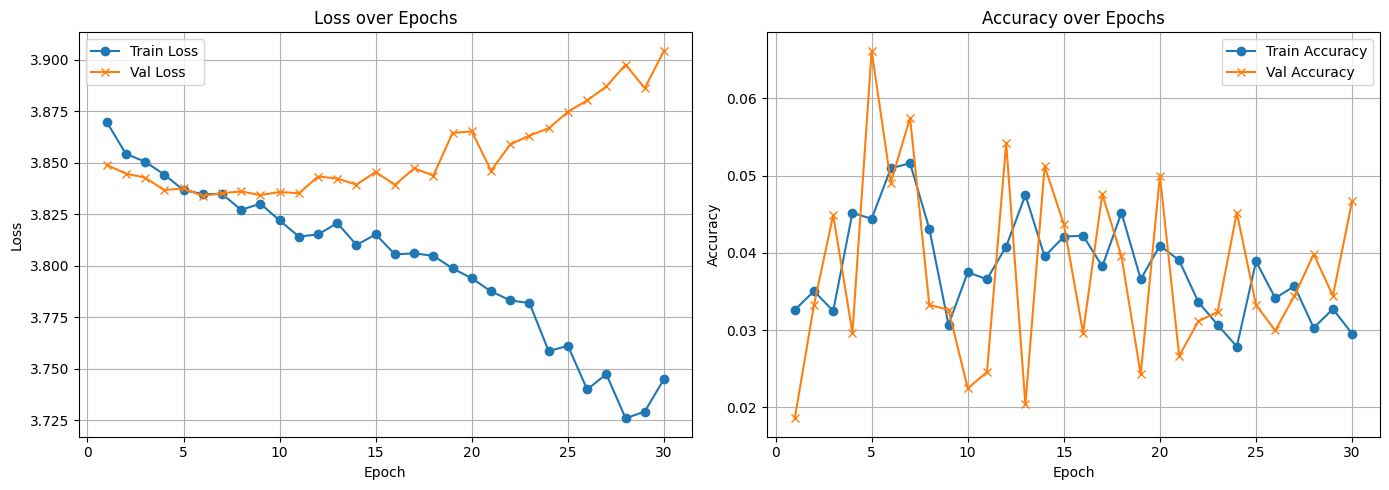

In [11]:
import matplotlib.pyplot as plt

# Plotting Losses and Accuracies
plt.figure(figsize=(14, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, marker='o', label='Train Loss')
plt.plot(range(1, epochs + 1), val_losses, marker='x', label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, marker='o', label='Train Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies, marker='x', label='Val Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Accuracy: 0.0467
Micro F1: 0.0467
Macro F1: 0.0097
   precision    recall  f1-score  support
0   0.000000  0.000000  0.000000    267.0
1   0.106430  0.162712  0.128686    295.0
2   0.141274  0.118881  0.129114    429.0
3   0.000000  0.000000  0.000000    185.0
4   0.000000  0.000000  0.000000    309.0


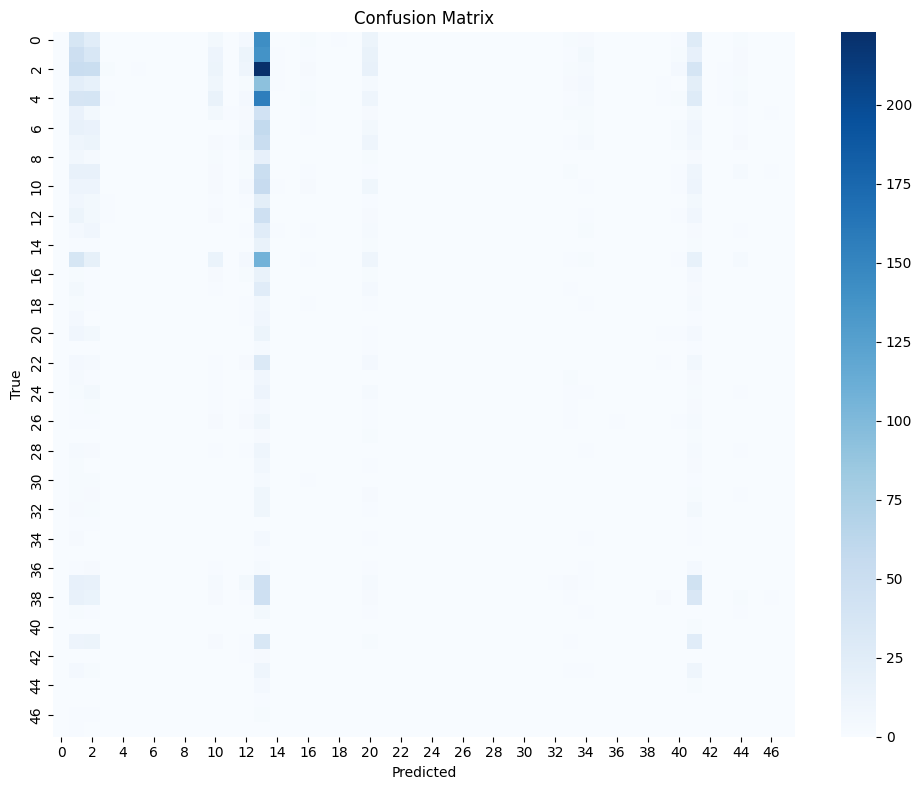

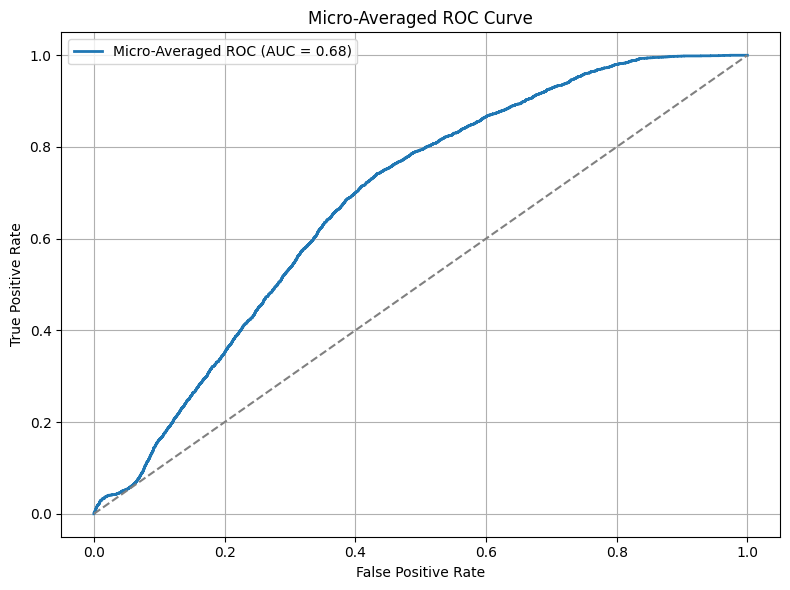

In [12]:
from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score,
    roc_auc_score, roc_curve, auc, accuracy_score
)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch

# Set model to evaluation mode
model.eval()
y_true, y_pred, y_proba = [], [], []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        preds = outputs.argmax(1)

        y_true.extend(targets.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_proba.extend(probs.cpu().numpy())

# Convert to arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_proba = np.array(y_proba)

# ----------------------------
# Metrics: Accuracy & F1
# ----------------------------
accuracy = accuracy_score(y_true, y_pred)
micro_f1 = f1_score(y_true, y_pred, average='micro')
macro_f1 = f1_score(y_true, y_pred, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"Micro F1: {micro_f1:.4f}")
print(f"Macro F1: {macro_f1:.4f}")

# ----------------------------
# Classification Report
# ----------------------------
report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
report_df = pd.DataFrame(report).transpose()
report_df.to_csv("classification_report.csv")
print(report_df.head())

# ----------------------------
# Confusion Matrix
# ----------------------------
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_true, y_pred), cmap="Blues", cbar=True)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.show()

# ----------------------------
# Micro-Averaged ROC AUC
# ----------------------------
y_true_bin = np.zeros_like(y_proba)
y_true_bin[np.arange(len(y_true)), y_true] = 1

fpr, tpr, _ = roc_curve(y_true_bin.ravel(), y_proba.ravel())
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Micro-Averaged ROC (AUC = {roc_auc:.2f})", lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("Micro-Averaged ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("micro_roc_curve.png")
plt.show()

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import torch
import numpy as np

# Step 1: Convert symptom list to documents
corpus = full_data["SYMPTOMS"].apply(lambda x: ' '.join(x))

# Step 2: TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(corpus)

# Step 3: Dimensionality reduction
svd = TruncatedSVD(n_components=100, random_state=42)
X_reduced = svd.fit_transform(X_tfidf)

# Step 4: Convert to tensor format
sequence_embeddings = torch.tensor(X_reduced, dtype=torch.float32).unsqueeze(1)

# Step 5: Encode full label set
label_encoder = LabelEncoder()
original_labels = label_encoder.fit_transform(full_data["ICD9_CODE"])
labels_tensor = torch.tensor(original_labels, dtype=torch.long)

# Step 6: Filter classes with at least 2 samples
_, counts = np.unique(labels_tensor.numpy(), return_counts=True)
keep_classes = np.where(counts >= 2)[0]
valid_indices = [i for i in range(len(labels_tensor)) if labels_tensor[i].item() in keep_classes]

sequence_embeddings = sequence_embeddings[valid_indices]
labels_tensor = labels_tensor[valid_indices]

# Step 7: Re-map filtered labels to 0...C-1 using new LabelEncoder
label_encoder_filtered = LabelEncoder()
labels_tensor = torch.tensor(
    label_encoder_filtered.fit_transform(labels_tensor.numpy()),
    dtype=torch.long
)

# Step 8: Stratified train/test split
X_train, X_test, y_train, y_test = train_test_split(
    sequence_embeddings, labels_tensor, test_size=0.3, stratify=labels_tensor, random_state=42
)

# Step 9: DataLoaders
train_loader = DataLoader(
    TensorDataset(X_train, y_train),
    batch_size=32,
    shuffle=True,
    pin_memory=True,
    drop_last=True
)

test_loader = DataLoader(
    TensorDataset(X_test, y_test),
    batch_size=32,
    pin_memory=True
)

print(f"TF-IDF shape: {sequence_embeddings.shape}, Remaining classes: {len(torch.unique(labels_tensor))}")

TF-IDF shape: torch.Size([11137, 1, 100]), Remaining classes: 48


In [14]:
# Step 1: Initialize model and move to GPU
input_dim_tfidf = sequence_embeddings.shape[2]  # Should be 100 after SVD
output_dim = len(torch.unique(labels_tensor))   # Matches remapped label space

model_tfidf = BiLSTMClassifier(
    input_dim=input_dim_tfidf,
    hidden_dim=64,
    output_dim=output_dim,
    num_layers=1  # or 3 if you want dropout
).to(device)

# Step 2: Compute class weights using updated labels
from sklearn.utils.class_weight import compute_class_weight

unique_classes = np.unique(labels_tensor.numpy())
weights = compute_class_weight(class_weight='balanced', classes=unique_classes, y=labels_tensor.numpy())
class_weights = torch.tensor(weights, dtype=torch.float32).to(device)

# Step 3: Define loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model_tfidf.parameters(), lr=0.001)

# Step 4: Metric tracking
tfidf_train_losses, tfidf_val_losses = [], []
tfidf_train_accuracies, tfidf_val_accuracies = [], []

print("Training BiLSTM on reduced TF-IDF representations...\n")
epochs = 200

# Step 5: Training loop
for epoch in range(epochs):
    model_tfidf.train()
    running_loss, correct, total = 0.0, 0, 0

    for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Train")):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model_tfidf(inputs)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        preds = outputs.argmax(1)
        correct += (preds == targets).sum().item()
        total += targets.size(0)

    train_loss = running_loss / total
    train_acc = correct / total
    tfidf_train_losses.append(train_loss)
    tfidf_train_accuracies.append(train_acc)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")

Training BiLSTM on reduced TF-IDF representations...



Epoch 1/200 - Train: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:00<00:00, 258.24it/s]


Epoch 1/200 | Train Loss: 3.8595 | Train Acc: 0.0410


Epoch 2/200 - Train: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:00<00:00, 279.63it/s]


Epoch 2/200 | Train Loss: 3.8374 | Train Acc: 0.0680


Epoch 3/200 - Train: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:00<00:00, 270.90it/s]


Epoch 3/200 | Train Loss: 3.8264 | Train Acc: 0.0745


Epoch 4/200 - Train: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 242.03it/s]


Epoch 4/200 | Train Loss: 3.8154 | Train Acc: 0.0567


Epoch 5/200 - Train: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 229.68it/s]


Epoch 5/200 | Train Loss: 3.7992 | Train Acc: 0.0581


Epoch 6/200 - Train: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 205.41it/s]


Epoch 6/200 | Train Loss: 3.7749 | Train Acc: 0.0688


Epoch 7/200 - Train: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 236.84it/s]


Epoch 7/200 | Train Loss: 3.7551 | Train Acc: 0.0737


Epoch 8/200 - Train: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 220.31it/s]


Epoch 8/200 | Train Loss: 3.7246 | Train Acc: 0.0548


Epoch 9/200 - Train: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 195.81it/s]


Epoch 9/200 | Train Loss: 3.6902 | Train Acc: 0.0530


Epoch 10/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 194.87it/s]


Epoch 10/200 | Train Loss: 3.6543 | Train Acc: 0.0548


Epoch 11/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 185.21it/s]


Epoch 11/200 | Train Loss: 3.6134 | Train Acc: 0.0495


Epoch 12/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 194.40it/s]


Epoch 12/200 | Train Loss: 3.5747 | Train Acc: 0.0468


Epoch 13/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 187.79it/s]


Epoch 13/200 | Train Loss: 3.5514 | Train Acc: 0.0469


Epoch 14/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 204.89it/s]


Epoch 14/200 | Train Loss: 3.5020 | Train Acc: 0.0460


Epoch 15/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 212.60it/s]


Epoch 15/200 | Train Loss: 3.4772 | Train Acc: 0.0455


Epoch 16/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 220.51it/s]


Epoch 16/200 | Train Loss: 3.4477 | Train Acc: 0.0413


Epoch 17/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:00<00:00, 244.96it/s]


Epoch 17/200 | Train Loss: 3.4051 | Train Acc: 0.0394


Epoch 18/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 234.10it/s]


Epoch 18/200 | Train Loss: 3.3842 | Train Acc: 0.0454


Epoch 19/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 204.03it/s]


Epoch 19/200 | Train Loss: 3.3448 | Train Acc: 0.0387


Epoch 20/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 207.16it/s]


Epoch 20/200 | Train Loss: 3.3333 | Train Acc: 0.0413


Epoch 21/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 239.17it/s]


Epoch 21/200 | Train Loss: 3.3271 | Train Acc: 0.0414


Epoch 22/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 200.33it/s]


Epoch 22/200 | Train Loss: 3.3247 | Train Acc: 0.0422


Epoch 23/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:00<00:00, 253.12it/s]


Epoch 23/200 | Train Loss: 3.2888 | Train Acc: 0.0422


Epoch 24/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:00<00:00, 264.71it/s]


Epoch 24/200 | Train Loss: 3.2441 | Train Acc: 0.0410


Epoch 25/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 235.69it/s]


Epoch 25/200 | Train Loss: 3.2360 | Train Acc: 0.0418


Epoch 26/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 242.03it/s]


Epoch 26/200 | Train Loss: 3.2188 | Train Acc: 0.0455


Epoch 27/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 224.58it/s]


Epoch 27/200 | Train Loss: 3.2225 | Train Acc: 0.0421


Epoch 28/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:00<00:00, 270.30it/s]


Epoch 28/200 | Train Loss: 3.2189 | Train Acc: 0.0426


Epoch 29/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:00<00:00, 262.70it/s]


Epoch 29/200 | Train Loss: 3.1667 | Train Acc: 0.0432


Epoch 30/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:00<00:00, 257.14it/s]


Epoch 30/200 | Train Loss: 3.1701 | Train Acc: 0.0445


Epoch 31/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 241.07it/s]


Epoch 31/200 | Train Loss: 3.1653 | Train Acc: 0.0427


Epoch 32/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 226.47it/s]


Epoch 32/200 | Train Loss: 3.1659 | Train Acc: 0.0422


Epoch 33/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 235.01it/s]


Epoch 33/200 | Train Loss: 3.1550 | Train Acc: 0.0415


Epoch 34/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 178.28it/s]


Epoch 34/200 | Train Loss: 3.1426 | Train Acc: 0.0426


Epoch 35/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:00<00:00, 257.96it/s]


Epoch 35/200 | Train Loss: 3.1357 | Train Acc: 0.0444


Epoch 36/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 221.11it/s]


Epoch 36/200 | Train Loss: 3.1382 | Train Acc: 0.0418


Epoch 37/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 200.33it/s]


Epoch 37/200 | Train Loss: 3.1474 | Train Acc: 0.0459


Epoch 38/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 206.98it/s]


Epoch 38/200 | Train Loss: 3.1255 | Train Acc: 0.0446


Epoch 39/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 198.21it/s]


Epoch 39/200 | Train Loss: 3.1123 | Train Acc: 0.0439


Epoch 40/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 229.46it/s]


Epoch 40/200 | Train Loss: 3.1105 | Train Acc: 0.0445


Epoch 41/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:00<00:00, 279.63it/s]


Epoch 41/200 | Train Loss: 3.1110 | Train Acc: 0.0448


Epoch 42/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:00<00:00, 266.45it/s]


Epoch 42/200 | Train Loss: 3.1054 | Train Acc: 0.0464


Epoch 43/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:00<00:00, 253.13it/s]


Epoch 43/200 | Train Loss: 3.1098 | Train Acc: 0.0472


Epoch 44/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 241.55it/s]


Epoch 44/200 | Train Loss: 3.0749 | Train Acc: 0.0481


Epoch 45/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:00<00:00, 251.55it/s]


Epoch 45/200 | Train Loss: 3.0766 | Train Acc: 0.0450


Epoch 46/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 222.94it/s]


Epoch 46/200 | Train Loss: 3.0858 | Train Acc: 0.0418


Epoch 47/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 189.40it/s]


Epoch 47/200 | Train Loss: 3.0642 | Train Acc: 0.0457


Epoch 48/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 220.51it/s]


Epoch 48/200 | Train Loss: 3.0718 | Train Acc: 0.0441


Epoch 49/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:00<00:00, 285.55it/s]


Epoch 49/200 | Train Loss: 3.0415 | Train Acc: 0.0426


Epoch 50/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:00<00:00, 282.56it/s]


Epoch 50/200 | Train Loss: 3.0759 | Train Acc: 0.0469


Epoch 51/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:00<00:00, 250.77it/s]


Epoch 51/200 | Train Loss: 3.0520 | Train Acc: 0.0482


Epoch 52/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 177.63it/s]


Epoch 52/200 | Train Loss: 3.0506 | Train Acc: 0.0490


Epoch 53/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:00<00:00, 255.52it/s]


Epoch 53/200 | Train Loss: 3.0353 | Train Acc: 0.0473


Epoch 54/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:00<00:00, 290.67it/s]


Epoch 54/200 | Train Loss: 3.0245 | Train Acc: 0.0469


Epoch 55/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:00<00:00, 266.16it/s]


Epoch 55/200 | Train Loss: 3.0134 | Train Acc: 0.0516


Epoch 56/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:00<00:00, 246.20it/s]


Epoch 56/200 | Train Loss: 3.0185 | Train Acc: 0.0466


Epoch 57/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 241.79it/s]


Epoch 57/200 | Train Loss: 3.0328 | Train Acc: 0.0532


Epoch 58/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 186.64it/s]


Epoch 58/200 | Train Loss: 3.0105 | Train Acc: 0.0495


Epoch 59/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 183.12it/s]


Epoch 59/200 | Train Loss: 3.0528 | Train Acc: 0.0500


Epoch 60/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 217.16it/s]


Epoch 60/200 | Train Loss: 3.0300 | Train Acc: 0.0504


Epoch 61/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 223.55it/s]


Epoch 61/200 | Train Loss: 3.0208 | Train Acc: 0.0513


Epoch 62/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:00<00:00, 291.37it/s]


Epoch 62/200 | Train Loss: 3.0085 | Train Acc: 0.0502


Epoch 63/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:00<00:00, 288.26it/s]


Epoch 63/200 | Train Loss: 3.0055 | Train Acc: 0.0500


Epoch 64/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:00<00:00, 251.03it/s]


Epoch 64/200 | Train Loss: 3.0158 | Train Acc: 0.0517


Epoch 65/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:00<00:00, 243.49it/s]


Epoch 65/200 | Train Loss: 2.9878 | Train Acc: 0.0494


Epoch 66/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 225.21it/s]


Epoch 66/200 | Train Loss: 2.9872 | Train Acc: 0.0509


Epoch 67/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 217.16it/s]


Epoch 67/200 | Train Loss: 2.9848 | Train Acc: 0.0486


Epoch 68/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 212.97it/s]


Epoch 68/200 | Train Loss: 2.9682 | Train Acc: 0.0545


Epoch 69/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 221.92it/s]


Epoch 69/200 | Train Loss: 2.9738 | Train Acc: 0.0534


Epoch 70/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 214.47it/s]


Epoch 70/200 | Train Loss: 2.9648 | Train Acc: 0.0541


Epoch 71/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 218.13it/s]


Epoch 71/200 | Train Loss: 2.9693 | Train Acc: 0.0514


Epoch 72/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 227.53it/s]


Epoch 72/200 | Train Loss: 2.9663 | Train Acc: 0.0553


Epoch 73/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 211.49it/s]


Epoch 73/200 | Train Loss: 2.9590 | Train Acc: 0.0559


Epoch 74/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 209.48it/s]


Epoch 74/200 | Train Loss: 2.9402 | Train Acc: 0.0559


Epoch 75/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 165.53it/s]


Epoch 75/200 | Train Loss: 2.9250 | Train Acc: 0.0585


Epoch 76/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:00<00:00, 258.51it/s]


Epoch 76/200 | Train Loss: 2.9227 | Train Acc: 0.0567


Epoch 77/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:00<00:00, 292.77it/s]


Epoch 77/200 | Train Loss: 2.9416 | Train Acc: 0.0545


Epoch 78/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:00<00:00, 268.21it/s]


Epoch 78/200 | Train Loss: 2.9366 | Train Acc: 0.0535


Epoch 79/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 179.73it/s]


Epoch 79/200 | Train Loss: 2.9227 | Train Acc: 0.0565


Epoch 80/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:00<00:00, 257.42it/s]


Epoch 80/200 | Train Loss: 2.9534 | Train Acc: 0.0550


Epoch 81/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 225.42it/s]


Epoch 81/200 | Train Loss: 2.8944 | Train Acc: 0.0562


Epoch 82/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:00<00:00, 285.21it/s]


Epoch 82/200 | Train Loss: 2.9450 | Train Acc: 0.0494


Epoch 83/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:00<00:00, 290.67it/s]


Epoch 83/200 | Train Loss: 2.9386 | Train Acc: 0.0568


Epoch 84/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:00<00:00, 254.99it/s]


Epoch 84/200 | Train Loss: 2.9226 | Train Acc: 0.0577


Epoch 85/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:00<00:00, 245.46it/s]


Epoch 85/200 | Train Loss: 2.9052 | Train Acc: 0.0556


Epoch 86/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 231.43it/s]


Epoch 86/200 | Train Loss: 2.9008 | Train Acc: 0.0577


Epoch 87/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 218.13it/s]


Epoch 87/200 | Train Loss: 2.8916 | Train Acc: 0.0567


Epoch 88/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 210.94it/s]


Epoch 88/200 | Train Loss: 2.8753 | Train Acc: 0.0593


Epoch 89/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 216.77it/s]


Epoch 89/200 | Train Loss: 2.8637 | Train Acc: 0.0566


Epoch 90/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 218.13it/s]


Epoch 90/200 | Train Loss: 2.8715 | Train Acc: 0.0594


Epoch 91/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 223.55it/s]


Epoch 91/200 | Train Loss: 2.8638 | Train Acc: 0.0550


Epoch 92/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 211.49it/s]


Epoch 92/200 | Train Loss: 2.8680 | Train Acc: 0.0599


Epoch 93/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 207.69it/s]


Epoch 93/200 | Train Loss: 2.8460 | Train Acc: 0.0619


Epoch 94/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 215.04it/s]


Epoch 94/200 | Train Loss: 2.8527 | Train Acc: 0.0616


Epoch 95/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 214.66it/s]


Epoch 95/200 | Train Loss: 2.8762 | Train Acc: 0.0602


Epoch 96/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 212.78it/s]


Epoch 96/200 | Train Loss: 2.8505 | Train Acc: 0.0590


Epoch 97/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 217.94it/s]


Epoch 97/200 | Train Loss: 2.8589 | Train Acc: 0.0562


Epoch 98/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 222.53it/s]


Epoch 98/200 | Train Loss: 2.8463 | Train Acc: 0.0617


Epoch 99/200 - Train: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 223.76it/s]


Epoch 99/200 | Train Loss: 2.8340 | Train Acc: 0.0651


Epoch 100/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 202.16it/s]


Epoch 100/200 | Train Loss: 2.8154 | Train Acc: 0.0613


Epoch 101/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 214.10it/s]


Epoch 101/200 | Train Loss: 2.8231 | Train Acc: 0.0631


Epoch 102/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 219.12it/s]


Epoch 102/200 | Train Loss: 2.8278 | Train Acc: 0.0604


Epoch 103/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 186.64it/s]


Epoch 103/200 | Train Loss: 2.7997 | Train Acc: 0.0612


Epoch 104/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:00<00:00, 297.79it/s]


Epoch 104/200 | Train Loss: 2.7943 | Train Acc: 0.0644


Epoch 105/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:00<00:00, 292.07it/s]


Epoch 105/200 | Train Loss: 2.7905 | Train Acc: 0.0616


Epoch 106/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 218.92it/s]


Epoch 106/200 | Train Loss: 2.7811 | Train Acc: 0.0652


Epoch 107/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 193.63it/s]


Epoch 107/200 | Train Loss: 2.7962 | Train Acc: 0.0626


Epoch 108/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:00<00:00, 244.71it/s]


Epoch 108/200 | Train Loss: 2.7706 | Train Acc: 0.0649


Epoch 109/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 230.11it/s]


Epoch 109/200 | Train Loss: 2.7667 | Train Acc: 0.0674


Epoch 110/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:00<00:00, 286.22it/s]


Epoch 110/200 | Train Loss: 2.7552 | Train Acc: 0.0674


Epoch 111/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 206.63it/s]


Epoch 111/200 | Train Loss: 2.7742 | Train Acc: 0.0653


Epoch 112/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 211.49it/s]


Epoch 112/200 | Train Loss: 2.7745 | Train Acc: 0.0666


Epoch 113/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 220.91it/s]


Epoch 113/200 | Train Loss: 2.7496 | Train Acc: 0.0646


Epoch 114/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 199.67it/s]


Epoch 114/200 | Train Loss: 2.7243 | Train Acc: 0.0689


Epoch 115/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 191.94it/s]


Epoch 115/200 | Train Loss: 2.7245 | Train Acc: 0.0683


Epoch 116/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 196.76it/s]


Epoch 116/200 | Train Loss: 2.7230 | Train Acc: 0.0660


Epoch 117/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 204.37it/s]


Epoch 117/200 | Train Loss: 2.7385 | Train Acc: 0.0676


Epoch 118/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:00<00:00, 274.89it/s]


Epoch 118/200 | Train Loss: 2.7176 | Train Acc: 0.0685


Epoch 119/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:00<00:00, 250.00it/s]


Epoch 119/200 | Train Loss: 2.7124 | Train Acc: 0.0683


Epoch 120/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 240.59it/s]


Epoch 120/200 | Train Loss: 2.7284 | Train Acc: 0.0676


Epoch 121/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:00<00:00, 295.62it/s]


Epoch 121/200 | Train Loss: 2.7092 | Train Acc: 0.0707


Epoch 122/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:00<00:00, 290.67it/s]


Epoch 122/200 | Train Loss: 2.7159 | Train Acc: 0.0725


Epoch 123/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:00<00:00, 256.06it/s]


Epoch 123/200 | Train Loss: 2.7180 | Train Acc: 0.0700


Epoch 124/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 239.64it/s]


Epoch 124/200 | Train Loss: 2.7115 | Train Acc: 0.0683


Epoch 125/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 226.68it/s]


Epoch 125/200 | Train Loss: 2.6707 | Train Acc: 0.0729


Epoch 126/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 208.94it/s]


Epoch 126/200 | Train Loss: 2.6742 | Train Acc: 0.0729


Epoch 127/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 227.96it/s]


Epoch 127/200 | Train Loss: 2.6935 | Train Acc: 0.0693


Epoch 128/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 219.71it/s]


Epoch 128/200 | Train Loss: 2.6843 | Train Acc: 0.0712


Epoch 129/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 211.86it/s]


Epoch 129/200 | Train Loss: 2.6789 | Train Acc: 0.0733


Epoch 130/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 216.00it/s]


Epoch 130/200 | Train Loss: 2.6481 | Train Acc: 0.0728


Epoch 131/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 205.41it/s]


Epoch 131/200 | Train Loss: 2.6540 | Train Acc: 0.0748


Epoch 132/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 219.12it/s]


Epoch 132/200 | Train Loss: 2.6298 | Train Acc: 0.0746


Epoch 133/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 230.99it/s]


Epoch 133/200 | Train Loss: 2.6446 | Train Acc: 0.0751


Epoch 134/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 221.11it/s]


Epoch 134/200 | Train Loss: 2.6240 | Train Acc: 0.0764


Epoch 135/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 223.76it/s]


Epoch 135/200 | Train Loss: 2.6206 | Train Acc: 0.0777


Epoch 136/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 210.39it/s]


Epoch 136/200 | Train Loss: 2.6094 | Train Acc: 0.0788


Epoch 137/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 213.16it/s]


Epoch 137/200 | Train Loss: 2.5975 | Train Acc: 0.0759


Epoch 138/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 216.19it/s]


Epoch 138/200 | Train Loss: 2.6101 | Train Acc: 0.0748


Epoch 139/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 218.92it/s]


Epoch 139/200 | Train Loss: 2.6233 | Train Acc: 0.0788


Epoch 140/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 222.53it/s]


Epoch 140/200 | Train Loss: 2.5931 | Train Acc: 0.0806


Epoch 141/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 201.66it/s]


Epoch 141/200 | Train Loss: 2.5794 | Train Acc: 0.0795


Epoch 142/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 216.58it/s]


Epoch 142/200 | Train Loss: 2.5795 | Train Acc: 0.0824


Epoch 143/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 212.23it/s]


Epoch 143/200 | Train Loss: 2.5426 | Train Acc: 0.0838


Epoch 144/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 215.43it/s]


Epoch 144/200 | Train Loss: 2.5867 | Train Acc: 0.0811


Epoch 145/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 217.94it/s]


Epoch 145/200 | Train Loss: 2.5851 | Train Acc: 0.0796


Epoch 146/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 176.86it/s]


Epoch 146/200 | Train Loss: 2.5272 | Train Acc: 0.0845


Epoch 147/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 216.58it/s]


Epoch 147/200 | Train Loss: 2.5407 | Train Acc: 0.0855


Epoch 148/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 206.11it/s]


Epoch 148/200 | Train Loss: 2.5167 | Train Acc: 0.0849


Epoch 149/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 207.16it/s]


Epoch 149/200 | Train Loss: 2.5506 | Train Acc: 0.0850


Epoch 150/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 229.68it/s]


Epoch 150/200 | Train Loss: 2.5469 | Train Acc: 0.0826


Epoch 151/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 214.10it/s]


Epoch 151/200 | Train Loss: 2.5516 | Train Acc: 0.0818


Epoch 152/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:00<00:00, 258.51it/s]


Epoch 152/200 | Train Loss: 2.5486 | Train Acc: 0.0832


Epoch 153/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:00<00:00, 273.03it/s]


Epoch 153/200 | Train Loss: 2.5251 | Train Acc: 0.0853


Epoch 154/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:00<00:00, 266.16it/s]


Epoch 154/200 | Train Loss: 2.5378 | Train Acc: 0.0881


Epoch 155/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:00<00:00, 245.46it/s]


Epoch 155/200 | Train Loss: 2.5055 | Train Acc: 0.0858


Epoch 156/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 237.77it/s]


Epoch 156/200 | Train Loss: 2.4897 | Train Acc: 0.0894


Epoch 157/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 218.72it/s]


Epoch 157/200 | Train Loss: 2.4993 | Train Acc: 0.0877


Epoch 158/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 218.13it/s]


Epoch 158/200 | Train Loss: 2.4857 | Train Acc: 0.0864


Epoch 159/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 211.12it/s]


Epoch 159/200 | Train Loss: 2.5213 | Train Acc: 0.0863


Epoch 160/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 215.81it/s]


Epoch 160/200 | Train Loss: 2.5032 | Train Acc: 0.0871


Epoch 161/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 209.66it/s]


Epoch 161/200 | Train Loss: 2.4581 | Train Acc: 0.0885


Epoch 162/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 206.63it/s]


Epoch 162/200 | Train Loss: 2.4691 | Train Acc: 0.0895


Epoch 163/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 215.24it/s]


Epoch 163/200 | Train Loss: 2.4526 | Train Acc: 0.0899


Epoch 164/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 171.37it/s]


Epoch 164/200 | Train Loss: 2.4756 | Train Acc: 0.0914


Epoch 165/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:00<00:00, 283.55it/s]


Epoch 165/200 | Train Loss: 2.4518 | Train Acc: 0.0923


Epoch 166/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:00<00:00, 287.23it/s]


Epoch 166/200 | Train Loss: 2.4776 | Train Acc: 0.0916


Epoch 167/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:00<00:00, 262.14it/s]


Epoch 167/200 | Train Loss: 2.4347 | Train Acc: 0.0948


Epoch 168/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 206.46it/s]


Epoch 168/200 | Train Loss: 2.4455 | Train Acc: 0.0923


Epoch 169/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 196.92it/s]


Epoch 169/200 | Train Loss: 2.4040 | Train Acc: 0.0954


Epoch 170/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 211.12it/s]


Epoch 170/200 | Train Loss: 2.4102 | Train Acc: 0.0904


Epoch 171/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 218.13it/s]


Epoch 171/200 | Train Loss: 2.3930 | Train Acc: 0.0968


Epoch 172/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 198.21it/s]


Epoch 172/200 | Train Loss: 2.4202 | Train Acc: 0.0950


Epoch 173/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 199.67it/s]


Epoch 173/200 | Train Loss: 2.3927 | Train Acc: 0.0967


Epoch 174/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 198.21it/s]


Epoch 174/200 | Train Loss: 2.3850 | Train Acc: 0.1006


Epoch 175/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 225.21it/s]


Epoch 175/200 | Train Loss: 2.3927 | Train Acc: 0.0947


Epoch 176/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:00<00:00, 287.57it/s]


Epoch 176/200 | Train Loss: 2.3586 | Train Acc: 0.0989


Epoch 177/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:00<00:00, 279.63it/s]


Epoch 177/200 | Train Loss: 2.3438 | Train Acc: 0.1011


Epoch 178/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 235.92it/s]


Epoch 178/200 | Train Loss: 2.3782 | Train Acc: 0.0983


Epoch 179/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 225.42it/s]


Epoch 179/200 | Train Loss: 2.3851 | Train Acc: 0.1025


Epoch 180/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 199.51it/s]


Epoch 180/200 | Train Loss: 2.3428 | Train Acc: 0.1039


Epoch 181/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 198.04it/s]


Epoch 181/200 | Train Loss: 2.3548 | Train Acc: 0.1022


Epoch 182/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 192.10it/s]


Epoch 182/200 | Train Loss: 2.3337 | Train Acc: 0.1028


Epoch 183/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 205.58it/s]


Epoch 183/200 | Train Loss: 2.3771 | Train Acc: 0.1037


Epoch 184/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 219.91it/s]


Epoch 184/200 | Train Loss: 2.3208 | Train Acc: 0.1030


Epoch 185/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 203.69it/s]


Epoch 185/200 | Train Loss: 2.3333 | Train Acc: 0.1030


Epoch 186/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 199.02it/s]


Epoch 186/200 | Train Loss: 2.3445 | Train Acc: 0.1051


Epoch 187/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 219.12it/s]


Epoch 187/200 | Train Loss: 2.3177 | Train Acc: 0.1051


Epoch 188/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 225.63it/s]


Epoch 188/200 | Train Loss: 2.3287 | Train Acc: 0.1060


Epoch 189/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 218.13it/s]


Epoch 189/200 | Train Loss: 2.3383 | Train Acc: 0.1087


Epoch 190/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 212.23it/s]


Epoch 190/200 | Train Loss: 2.3036 | Train Acc: 0.1066


Epoch 191/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 229.46it/s]


Epoch 191/200 | Train Loss: 2.3114 | Train Acc: 0.1044


Epoch 192/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:00<00:00, 279.95it/s]


Epoch 192/200 | Train Loss: 2.3211 | Train Acc: 0.1070


Epoch 193/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:00<00:00, 246.95it/s]


Epoch 193/200 | Train Loss: 2.2726 | Train Acc: 0.1074


Epoch 194/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 227.95it/s]


Epoch 194/200 | Train Loss: 2.2678 | Train Acc: 0.1058


Epoch 195/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:00<00:00, 251.81it/s]


Epoch 195/200 | Train Loss: 2.2418 | Train Acc: 0.1119


Epoch 196/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 228.81it/s]


Epoch 196/200 | Train Loss: 2.2701 | Train Acc: 0.1075


Epoch 197/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 217.16it/s]


Epoch 197/200 | Train Loss: 2.2632 | Train Acc: 0.1110


Epoch 198/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 225.21it/s]


Epoch 198/200 | Train Loss: 2.2951 | Train Acc: 0.1101


Epoch 199/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 186.35it/s]


Epoch 199/200 | Train Loss: 2.2582 | Train Acc: 0.1093


Epoch 200/200 - Train: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 243/243 [00:01<00:00, 209.66it/s]

Epoch 200/200 | Train Loss: 2.2718 | Train Acc: 0.1092


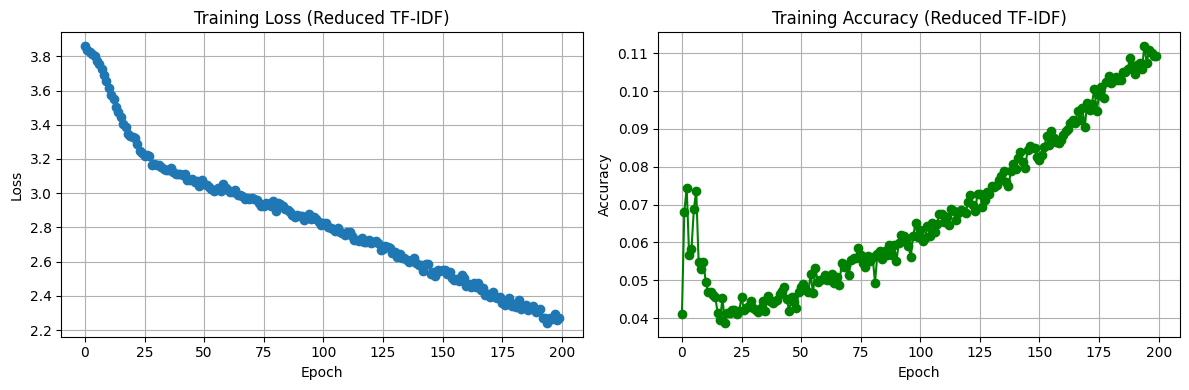

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Plot loss curve
plt.subplot(1, 2, 1)
plt.plot(tfidf_train_losses, marker='o')
plt.title("Training Loss (Reduced TF-IDF)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

# Plot accuracy curve
plt.subplot(1, 2, 2)
plt.plot(tfidf_train_accuracies, marker='o', color='green')
plt.title("Training Accuracy (Reduced TF-IDF)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()

[TF-IDF BiLSTM] Accuracy: 0.0150, Micro F1: 0.0150, Macro F1: 0.0114


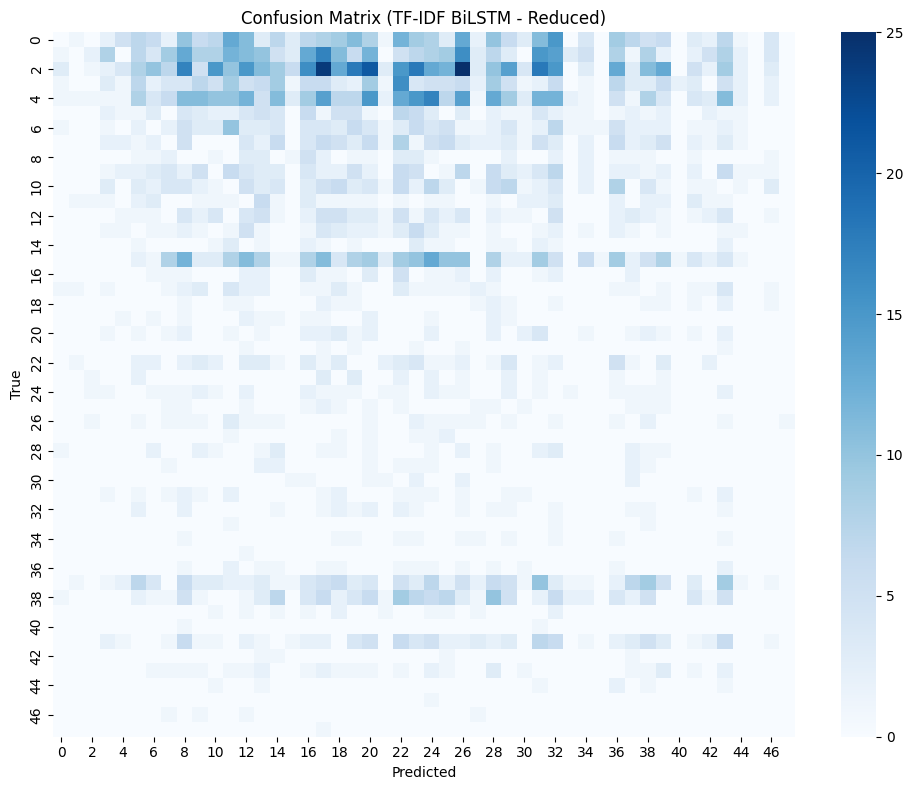

[Word2Vec BiLSTM] Accuracy: 0.0467, Micro F1: 0.0467, Macro F1: 0.0097


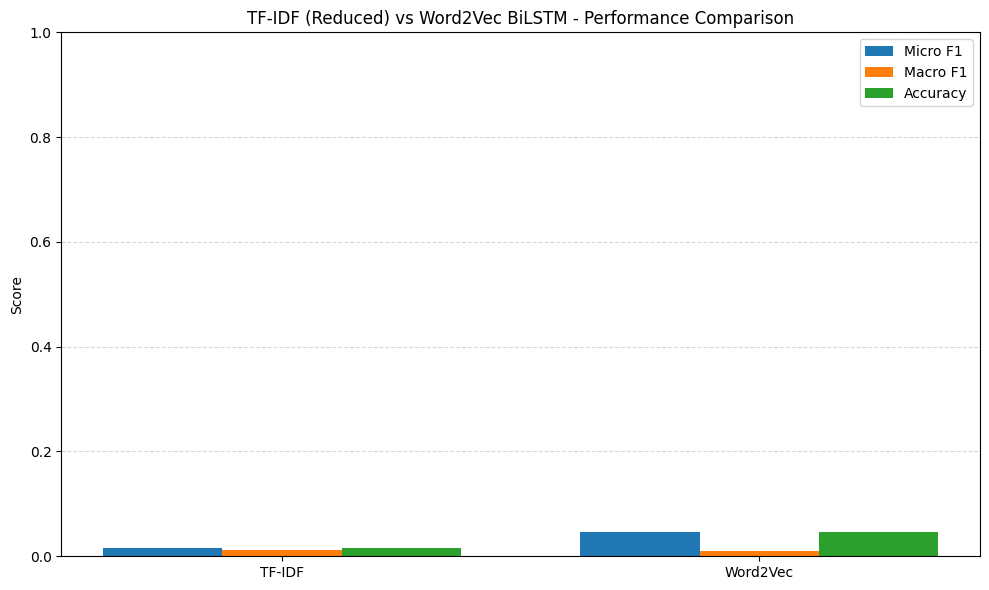

In [18]:
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch

# ------------------------------------------
# 1. Evaluate TF-IDF BiLSTM (Reduced SVD Version)
# ------------------------------------------
model_tfidf.eval()
y_true_tfidf, y_pred_tfidf = [], []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(model_tfidf.fc.weight.device)
        outputs = model_tfidf(inputs)
        preds = outputs.argmax(1)
        y_true_tfidf.extend(targets.cpu().numpy())
        y_pred_tfidf.extend(preds.cpu().numpy())

micro_f1_tfidf = f1_score(y_true_tfidf, y_pred_tfidf, average='micro')
macro_f1_tfidf = f1_score(y_true_tfidf, y_pred_tfidf, average='macro')
acc_tfidf = accuracy_score(y_true_tfidf, y_pred_tfidf)

print(f"[TF-IDF BiLSTM] Accuracy: {acc_tfidf:.4f}, Micro F1: {micro_f1_tfidf:.4f}, Macro F1: {macro_f1_tfidf:.4f}")

# Save classification report
report_tfidf = classification_report(y_true_tfidf, y_pred_tfidf, output_dict=True)
report_df = pd.DataFrame(report_tfidf).transpose()
report_df.to_csv("tfidf_reduced_classification_report.csv", index=True)

# Confusion matrix
conf_mat = confusion_matrix(y_true_tfidf, y_pred_tfidf)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, cmap="Blues", cbar=True)
plt.title("Confusion Matrix (TF-IDF BiLSTM - Reduced)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# ------------------------------------------
# 2. Word2Vec BiLSTM Scores (Assumes `y_true` and `y_pred` exist)
# ------------------------------------------
micro_f1_w2v = f1_score(y_true, y_pred, average='micro')
macro_f1_w2v = f1_score(y_true, y_pred, average='macro')
acc_w2v = accuracy_score(y_true, y_pred)

print(f"[Word2Vec BiLSTM] Accuracy: {acc_w2v:.4f}, Micro F1: {micro_f1_w2v:.4f}, Macro F1: {macro_f1_w2v:.4f}")

# ------------------------------------------
# 3. F1 & Accuracy Comparison Bar Chart
# ------------------------------------------
labels = ['TF-IDF', 'Word2Vec']
micro_f1s = [micro_f1_tfidf, micro_f1_w2v]
macro_f1s = [macro_f1_tfidf, macro_f1_w2v]
accuracies = [acc_tfidf, acc_w2v]

x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(10, 6))
plt.bar(x - width, micro_f1s, width, label='Micro F1')
plt.bar(x, macro_f1s, width, label='Macro F1')
plt.bar(x + width, accuracies, width, label='Accuracy')
plt.xticks(x, labels)
plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("TF-IDF (Reduced) vs Word2Vec BiLSTM - Performance Comparison")
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import torch
import numpy as np

# Step 1: Convert symptom list to documents
corpus = full_data["SYMPTOMS"].apply(lambda x: ' '.join(x))

# Step 2: TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(corpus)

# Step 3: Scale TF-IDF if needed (optional)
# from sklearn.preprocessing import StandardScaler
# X_tfidf_scaled = StandardScaler().fit_transform(X_tfidf.toarray())
X_tfidf_scaled = X_tfidf.toarray()

# Step 4: Dimensionality reduction
svd = TruncatedSVD(n_components=100, random_state=42)
X_reduced = svd.fit_transform(X_tfidf_scaled)

# Step 5: Convert to tensor format
sequence_embeddings = torch.tensor(X_reduced, dtype=torch.float32).unsqueeze(1)

# Step 6: Encode full label set
label_encoder = LabelEncoder()
original_labels = label_encoder.fit_transform(full_data["ICD9_CODE"])
labels_tensor = torch.tensor(original_labels, dtype=torch.long)

# Step 7: Filter classes with at least 2 samples
_, counts = np.unique(labels_tensor.numpy(), return_counts=True)
keep_classes = np.where(counts >= 2)[0]
valid_indices = [i for i in range(len(labels_tensor)) if labels_tensor[i].item() in keep_classes]

sequence_embeddings = sequence_embeddings[valid_indices]
labels_tensor = labels_tensor[valid_indices]

# Step 8: Re-map filtered labels to 0...C-1
label_encoder_filtered = LabelEncoder()
labels_tensor = torch.tensor(
    label_encoder_filtered.fit_transform(labels_tensor.numpy()),
    dtype=torch.long
)

# Step 9: Filtered symptom data for indexing in hybrid block
filtered_data = full_data.iloc[valid_indices].reset_index(drop=True)

# Step 10: Stratified train/test split
X_train, X_test, y_train, y_test = train_test_split(
    sequence_embeddings, labels_tensor, test_size=0.3, stratify=labels_tensor, random_state=42
)

# Step 11: DataLoaders
train_loader = DataLoader(
    TensorDataset(X_train, y_train),
    batch_size=32,
    shuffle=True,
    pin_memory=True,
    drop_last=True
)

test_loader = DataLoader(
    TensorDataset(X_test, y_test),
    batch_size=32,
    pin_memory=True
)

print(f"TF-IDF shape: {sequence_embeddings.shape}, Remaining classes: {len(torch.unique(labels_tensor))}")

TF-IDF shape: torch.Size([11137, 1, 100]), Remaining classes: 48


In [36]:
MAX_SEQ_LEN = 100
hybrid_sequences = []
hybrid_labels = []

for i in range(len(filtered_data)):
    tfidf_vec = X_tfidf_svd[i]  # shape (100,)
    hybrid_seq = []

    for word in filtered_data["SYMPTOMS"].iloc[i][:MAX_SEQ_LEN]:
        if word in w2v_model.wv:
            w2v_vec = w2v_model.wv[word]  # shape (50,)
            hybrid_vec = np.concatenate([w2v_vec, tfidf_vec])  # shape (150,)
            hybrid_seq.append(hybrid_vec)

    if hybrid_seq:
        hybrid_sequences.append(torch.tensor(hybrid_seq, dtype=torch.float32))
        hybrid_labels.append(labels_tensor[i].item())

In [37]:
print(hybrid_sequences[0].shape)  # Should be something like (sequence_len, 150)

torch.Size([41, 150])


In [38]:
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import TensorDataset, DataLoader
import torch

# Step 1: Pad updated hybrid sequences
padded_hybrid = pad_sequence(hybrid_sequences, batch_first=True)

# Step 2: Remap hybrid labels to 0...C-1
label_encoder_hybrid = LabelEncoder()
remapped_labels = label_encoder_hybrid.fit_transform(hybrid_labels)
labels_hybrid = torch.tensor(remapped_labels, dtype=torch.long)

# Step 3: Stratified train/test split
X_train_hybrid, X_test_hybrid, y_train_hybrid, y_test_hybrid = train_test_split(
    padded_hybrid, labels_hybrid, test_size=0.3, stratify=labels_hybrid, random_state=42
)

# Step 4: DataLoaders
train_loader_hybrid = DataLoader(TensorDataset(X_train_hybrid, y_train_hybrid), batch_size=32, shuffle=True)
test_loader_hybrid = DataLoader(TensorDataset(X_test_hybrid, y_test_hybrid), batch_size=32)

# Step 5: Confirm everything looks good
print(f"Hybrid padded shape: {padded_hybrid.shape}")
print(f"Training samples: {X_train_hybrid.shape[0]} | Test samples: {X_test_hybrid.shape[0]}")
print(f"Label classes: {torch.unique(labels_hybrid)}")


Hybrid padded shape: torch.Size([11132, 100, 150])
Training samples: 7792 | Test samples: 3340
Label classes: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47])


Training BiLSTM on HYBRID sequences...

Epoch 1/30 | Loss: 3.8569 | Accuracy: 0.0439
Epoch 2/30 | Loss: 3.8384 | Accuracy: 0.0484
Epoch 3/30 | Loss: 3.8287 | Accuracy: 0.0456
Epoch 4/30 | Loss: 3.8180 | Accuracy: 0.0494
Epoch 5/30 | Loss: 3.8008 | Accuracy: 0.0468
Epoch 6/30 | Loss: 3.7933 | Accuracy: 0.0418
Epoch 7/30 | Loss: 3.7872 | Accuracy: 0.0432
Epoch 8/30 | Loss: 3.7774 | Accuracy: 0.0411
Epoch 9/30 | Loss: 3.7616 | Accuracy: 0.0323
Epoch 10/30 | Loss: 3.7329 | Accuracy: 0.0364
Epoch 11/30 | Loss: 3.7150 | Accuracy: 0.0326
Epoch 12/30 | Loss: 3.6785 | Accuracy: 0.0267
Epoch 13/30 | Loss: 3.6554 | Accuracy: 0.0316
Epoch 14/30 | Loss: 3.6236 | Accuracy: 0.0273
Epoch 15/30 | Loss: 3.5776 | Accuracy: 0.0309
Epoch 16/30 | Loss: 3.5556 | Accuracy: 0.0302
Epoch 17/30 | Loss: 3.5224 | Accuracy: 0.0291
Epoch 18/30 | Loss: 3.5042 | Accuracy: 0.0282
Epoch 19/30 | Loss: 3.4872 | Accuracy: 0.0289
Epoch 20/30 | Loss: 3.4616 | Accuracy: 0.0298
Epoch 21/30 | Loss: 3.4332 | Accuracy: 0.0289
Epo

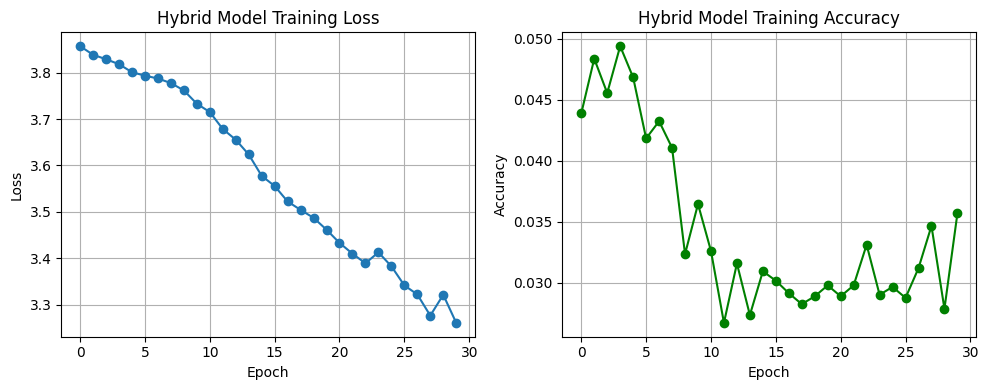

In [39]:
from sklearn.utils.class_weight import compute_class_weight
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Step 1: Define model
input_dim_hybrid = 150  # 50 Word2Vec + 100 TF-IDF
output_dim_hybrid = len(torch.unique(y_train_hybrid))

model_hybrid = BiLSTMClassifier(
    input_dim=input_dim_hybrid,
    hidden_dim=64,
    output_dim=output_dim_hybrid
).to(device)

# Step 2: Compute class weights
unique_classes = np.unique(y_train_hybrid.numpy())
weights = compute_class_weight(
    class_weight='balanced',
    classes=unique_classes,
    y=y_train_hybrid.numpy()
)

class_weights = torch.zeros(output_dim_hybrid, dtype=torch.float32)
class_weights[unique_classes] = torch.tensor(weights, dtype=torch.float32)
class_weights = class_weights.to(device)

# Step 3: Define loss and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model_hybrid.parameters(), lr=0.0005)

# Step 4: Train
epochs = 30
hybrid_train_losses = []
hybrid_train_accuracies = []

print("Training BiLSTM on HYBRID sequences...\n")

for epoch in range(epochs):
    model_hybrid.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in train_loader_hybrid:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model_hybrid(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        preds = outputs.argmax(1)
        correct += (preds == targets).sum().item()
        total += targets.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    hybrid_train_losses.append(epoch_loss)
    hybrid_train_accuracies.append(epoch_acc)

    print(f"Epoch {epoch+1}/{epochs} | Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.4f}")

# Step 5: Plot results
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(hybrid_train_losses, marker='o')
plt.title("Hybrid Model Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(hybrid_train_accuracies, marker='o', color='green')
plt.title("Hybrid Model Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)

plt.tight_layout()
plt.savefig("fig_hybrid_training_curves_weighted_ce.png", dpi=300)
plt.show()

In [40]:
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix

model_hybrid.eval()
y_true_hybrid, y_pred_hybrid = [], []

with torch.no_grad():
    for inputs, targets in test_loader_hybrid:
        inputs = inputs.to(device)
        outputs = model_hybrid(inputs)
        preds = outputs.argmax(1).cpu().numpy()
        y_true_hybrid.extend(targets.numpy())
        y_pred_hybrid.extend(preds)

micro_f1_hybrid = f1_score(y_true_hybrid, y_pred_hybrid, average='micro')
macro_f1_hybrid = f1_score(y_true_hybrid, y_pred_hybrid, average='macro')
acc_hybrid = accuracy_score(y_true_hybrid, y_pred_hybrid)

print(f"[Hybrid BiLSTM] Accuracy: {acc_hybrid:.4f}, Micro F1: {micro_f1_hybrid:.4f}, Macro F1: {macro_f1_hybrid:.4f}")

[Hybrid BiLSTM] Accuracy: 0.0120, Micro F1: 0.0120, Macro F1: 0.0095


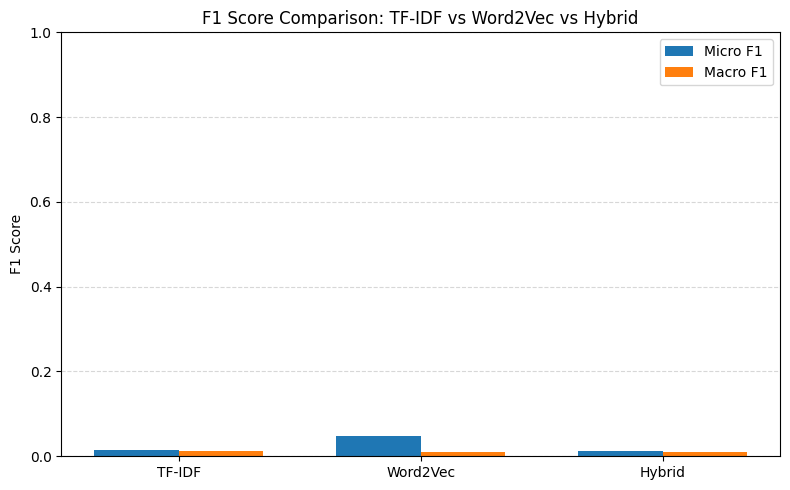

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Bar chart comparison
labels = ['TF-IDF', 'Word2Vec', 'Hybrid']
micro_f1s = [micro_f1_tfidf, micro_f1_w2v, micro_f1_hybrid]
macro_f1s = [macro_f1_tfidf, macro_f1_w2v, macro_f1_hybrid]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, micro_f1s, width, label='Micro F1')
plt.bar(x + width/2, macro_f1s, width, label='Macro F1')
plt.xticks(x, labels)
plt.ylim(0, 1)
plt.ylabel("F1 Score")
plt.title("F1 Score Comparison: TF-IDF vs Word2Vec vs Hybrid")
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Hybrid BiLSTM → Micro F1: 0.0120, Macro F1: 0.0095
   precision    recall  f1-score  support
0       0.00  0.000000  0.000000    267.0
1       0.00  0.000000  0.000000    295.0
2       0.00  0.000000  0.000000    429.0
3       0.20  0.005405  0.010526    185.0
4       0.25  0.003236  0.006390    309.0


C:\Users\Allen\anaconda3\envs\disease_bilstm\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Allen\anaconda3\envs\disease_bilstm\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Allen\anaconda3\envs\disease_bilstm\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

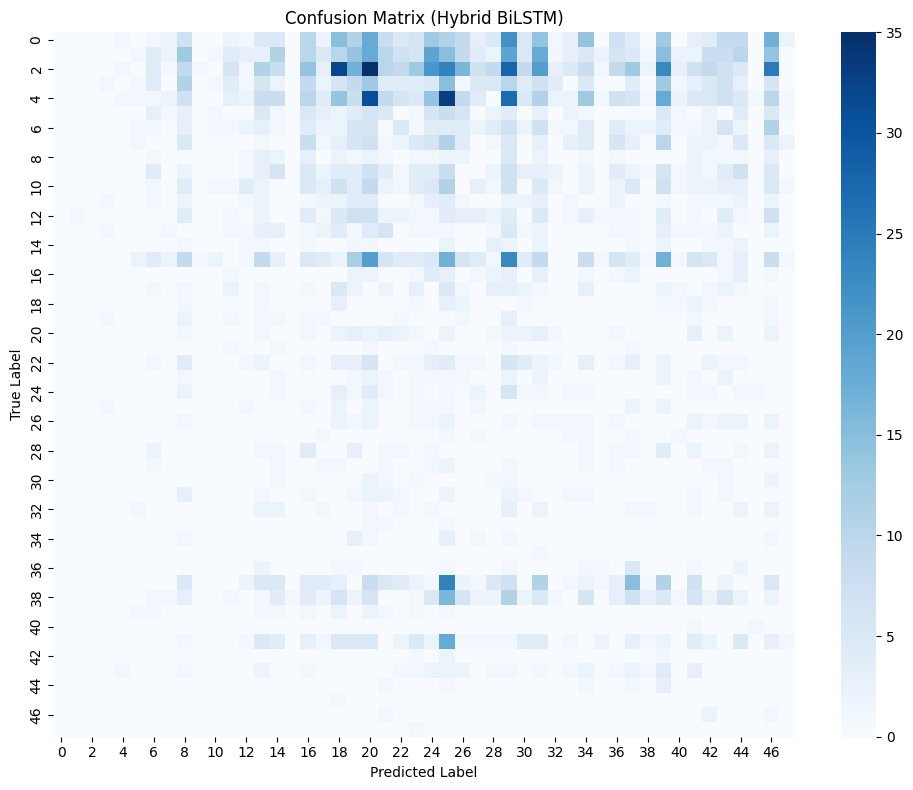

In [43]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Evaluate Hybrid Model
model_hybrid.eval()
y_true_hybrid, y_pred_hybrid = [], []

with torch.no_grad():
    for inputs, targets in test_loader_hybrid:
        inputs = inputs.to(device)
        outputs = model_hybrid(inputs)
        preds = outputs.argmax(1).cpu().numpy()
        y_true_hybrid.extend(targets.numpy())
        y_pred_hybrid.extend(preds)

# F1 Scores
micro_f1_hybrid = f1_score(y_true_hybrid, y_pred_hybrid, average='micro')
macro_f1_hybrid = f1_score(y_true_hybrid, y_pred_hybrid, average='macro')
print(f"Hybrid BiLSTM → Micro F1: {micro_f1_hybrid:.4f}, Macro F1: {macro_f1_hybrid:.4f}")

# Save classification report
report = classification_report(y_true_hybrid, y_pred_hybrid, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df.to_csv("hybrid_classification_report.csv")
print(report_df.head())

# Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_true_hybrid, y_pred_hybrid), cmap="Blues", annot=False, cbar=True)
plt.title("Confusion Matrix (Hybrid BiLSTM)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.savefig("fig_hybrid_confusion_matrix.png", dpi=300)
plt.show()

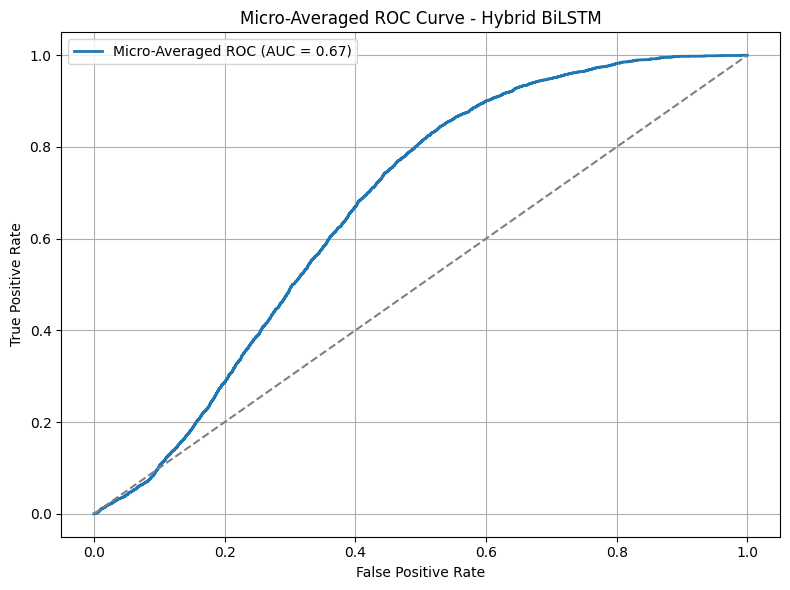

In [45]:
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

# Use correct number of classes for hybrid label encoder
num_classes = len(label_encoder_hybrid.classes_)

# One-hot encode y_true
y_true_bin = np.zeros((len(y_true_hybrid), num_classes))
y_true_bin[np.arange(len(y_true_hybrid)), y_true_hybrid] = 1

# Get prediction probabilities
y_proba_hybrid = []
model_hybrid.eval()
with torch.no_grad():
    for inputs, _ in test_loader_hybrid:
        inputs = inputs.to(device)
        outputs = model_hybrid(inputs)
        probs = torch.softmax(outputs, dim=1)
        y_proba_hybrid.extend(probs.cpu().numpy())

y_proba_hybrid = np.array(y_proba_hybrid)

# Sanity check
assert y_true_bin.shape == y_proba_hybrid.shape, f"Mismatched shapes: {y_true_bin.shape} vs {y_proba_hybrid.shape}"

# Micro-average ROC curve
fpr, tpr, _ = roc_curve(y_true_bin.ravel(), y_proba_hybrid.ravel())
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"Micro-Averaged ROC (AUC = {roc_auc:.2f})", lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("Micro-Averaged ROC Curve - Hybrid BiLSTM")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("fig_hybrid_micro_roc_auc.png", dpi=300)
plt.show()